### what data triggers the workflow?

In [3]:
import os
root = "/".join(os.getcwd().split("/")[:-1])
students = os.path.join(root, "data", "raw", "students")
new_students = [f"{i}-{f}" for i, f in enumerate(os.listdir(students))]
old_students = os.listdir(students)
for old, new in zip(old_students, new_students):
    os.rename(os.path.join(students, old), os.path.join(students, new))

In [1]:
from functions import text_extraction
import os
root = "/".join(os.getcwd().split("/")[:-1])
data_path = os.path.join(root, "data", "raw")
resumes_path = os.path.join(data_path, "cv")
job_des_path = os.path.join(data_path, "job", "data_role_des.txt")
job_des = text_extraction(job_des_path)
resumes = {
    f.split("-")[0] : text_extraction(os.path.join(resumes_path, f)) for f in os.listdir(resumes_path)
}

### what do i need for the tournament version 2?
**components**
- skills specialist agents
- aggregator and selector agent
- tournament referee agent (reduce ambiguity in the loop)

#### specialised agents

In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from typing import List


load_dotenv()

MODEL_NAME = "gpt-4o-mini-2024-07-18"

class TechnicalEvaluation(BaseModel):
    score : int = Field(description = "score of the candidate on the technical skill component")
    reasons : List[str] = Field(description = "list of reasons as to why the candidate has the score")


technical_agent = create_react_agent(
    model = ChatOpenAI(model = MODEL_NAME),
    tools = [],
    prompt = (
        "You are an expert recruiter specialized on evaluting "
        "the technical expertise of candidates.\n"
        "INSTRUCTIONS:\n"
        "- assist ONLY on evaluating a candidate on a set of technical skills or knowledge\n"
        "- after you are done with your task, respond to the supervisor directly\n"
        "- respond only with the results of your work, do not include any other text"
    ),
    response_format = TechnicalEvaluation,
    name = "technical_evaluator"
)

test_prompt = ChatPromptTemplate.from_messages(messages = [
    (
        "human",
        "Please help me rate the technical skills of a candidate for the following job description:\n"
        "Job description:\n\n{job_description}\n\n"
        "Candidate resume:\n\n{candidate_resume}"
    )
])

test_chain = test_prompt | technical_agent

test_response = test_chain.invoke({
    "job_description": job_des,
    "candidate_resume" : resumes['0176a86af53206ae']
})

test_response

{'messages': [HumanMessage(content='Please help me rate the technical skills of a candidate for the following job description:\nJob description:\n\nGraduate Consultant - Data & Analytics\nAre you a recent graduate with a passion for data and a desire to build a career in analytics and business transformation? Do you enjoy solving complex problems and delivering innovative, data-driven solutions that empower businesses? If so, Synogize is excited to connect with you!\n \nWe are seeking a motivated Graduate Consultant to join our growing team of Data & Analytics professionals in Melbourne. This is an exciting opportunity to launch your career in a dynamic field, working alongside experienced consultants on impactful projects. Applicants must have full working rights in Australia.\n \nAbout You\nYou are someone who:\nIs eager to collaborate with clients to develop tailored data and analytics solutions.\nEnjoys problem-solving and continuously seeks to optimize the use of data.\nHas a stro

In [3]:
test_response['messages']

[HumanMessage(content='Please help me rate the technical skills of a candidate for the following job description:\nJob description:\n\nGraduate Consultant - Data & Analytics\nAre you a recent graduate with a passion for data and a desire to build a career in analytics and business transformation? Do you enjoy solving complex problems and delivering innovative, data-driven solutions that empower businesses? If so, Synogize is excited to connect with you!\n \nWe are seeking a motivated Graduate Consultant to join our growing team of Data & Analytics professionals in Melbourne. This is an exciting opportunity to launch your career in a dynamic field, working alongside experienced consultants on impactful projects. Applicants must have full working rights in Australia.\n \nAbout You\nYou are someone who:\nIs eager to collaborate with clients to develop tailored data and analytics solutions.\nEnjoys problem-solving and continuously seeks to optimize the use of data.\nHas a strong interest i

In [4]:
test_response['structured_response']

TechnicalEvaluation(score=9, reasons=['Strong proficiency in SQL and data transformation tools like Python and Pandas', 'Extensive experience in building ETL pipelines and processing large datasets', 'Demonstrated ability to create interactive dashboards using Tableau and Power BI', 'Proven track record of collaborating with clients and stakeholders to provide actionable insights', "Solid academic background with a Master's in Data Science and Bachelor's in Computer Science", 'Experience in machine learning and advanced data analytics techniques', 'Familiarity with cloud platforms like Snowflake and BigQuery, aligning with job requirements', 'Adept at ensuring data quality and accuracy through testing and governance protocols'])

In [95]:
for m in test_response['messages']:
    m.pretty_print()

================================ Human Message =================================

Please help me rate the technical skills of a candidate for the following job description:
Job description:

Graduate Consultant - Data & Analytics
Are you a recent graduate with a passion for data and a desire to build a career in analytics and business transformation? Do you enjoy solving complex problems and delivering innovative, data-driven solutions that empower businesses? If so, Synogize is excited to connect with you!
 
We are seeking a motivated Graduate Consultant to join our growing team of Data & Analytics professionals in Melbourne. This is an exciting opportunity to launch your career in a dynamic field, working alongside experienced consultants on impactful projects. Applicants must have full working rights in Australia.
 
About You
You are someone who:
Is eager to collaborate with clients to develop tailored data and analytics solutions.
Enjoys problem-solving and continuously seeks to op

#### supervisor agent

In [3]:
from langgraph_supervisor import create_supervisor

class SoftSkillsEvaluation(BaseModel):
    score : int = Field(description = "score of the candidate on the soft skills component")
    reasons : List[str] = Field(description = "list of reasons as to why the candidate has the score")


soft_skills_agent = create_react_agent(
    model = ChatOpenAI(model = MODEL_NAME),
    tools = [],
    prompt = (
        "You are an expert recruiter specialized on evaluting "
        "the soft skills of candidates.\n"
        "INSTRUCTIONS:\n"
        "- assist ONLY on evaluating a candidate on their soft skills\n"
        "- after you are done with your task, respond to the supervisor directly\n"
        "- respond only with the results of your work, do not include any other text"
    ),
    response_format = SoftSkillsEvaluation,
    name = "soft_skill_evaluator"
)

supervisor = create_supervisor(
    model = ChatOpenAI(model = MODEL_NAME),
    agents = [soft_skills_agent, technical_agent],
    prompt = (
        "You are supervisor managing two agents.\n"
        "- a technical evaluator agent, assigned to evaluate candidates on their "
        "technical skills for the role and provide reasons why.\n"
        "- a soft skills evaluator agent, assigned to evaluate candidates on their "
        "soft skills for the role and provide reasons why.\n"
        "Please assign the work to one agent at the time, so do not call agents in parallel. "
        "Do not do any work yourself"
    ),
    add_handoff_back_messages = True,
    output_mode = "full_history"
).compile()


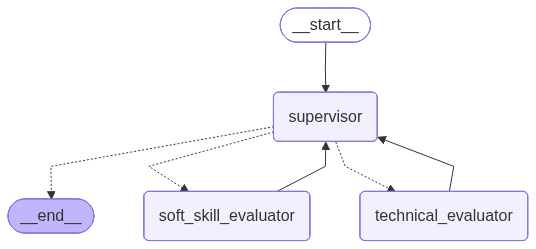

In [4]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

#### how would that work?

In [5]:
test = supervisor.invoke({
    "messages" : [
        {
            "role" : "user",
            "content" : f"can you help me analyzse the technical and soft skills of the following candidates:\ncandidate resume: {resumes['0176a86af53206ae']}"
        }
    ]
})
test

{'messages': [HumanMessage(content='can you help me analyzse the technical and soft skills of the following candidates:\ncandidate resume: Sahil Dwivedi\nData Analyst\nMelbourne, Vic | +61- 040 220 9556 | sahild091999@gmail.com | LinkedIn\nSUMMARY\nExperienced Data Analyst with over 3 years of hands-on experience in data analysis, predictive modeling, and business\nintelligence. Skilled in using tools such as Python, SQL, Power BI, Tableau, and Excel to collect, clean, transform, and visualize\nlarge datasets, enabling data-driven decision-making across business functions. Proficient in developing ETL pipelines,\nforecasting models, and interactive dashboards to optimize inventory, identify trends, and improve operational efficiency. Adept\nat statistical analysis, machine learning, and data storytelling to communicate insights to both technical and non-technical\nstakeholders. Strong team collaborator with a proven ability to work cross-functionally in agile environments, solve comple

In [6]:
for m in test['messages']:
    m.pretty_print()

================================ Human Message =================================

can you help me analyzse the technical and soft skills of the following candidates:
candidate resume: Sahil Dwivedi
Data Analyst
Melbourne, Vic | +61- 040 220 9556 | sahild091999@gmail.com | LinkedIn
SUMMARY
Experienced Data Analyst with over 3 years of hands-on experience in data analysis, predictive modeling, and business
intelligence. Skilled in using tools such as Python, SQL, Power BI, Tableau, and Excel to collect, clean, transform, and visualize
large datasets, enabling data-driven decision-making across business functions. Proficient in developing ETL pipelines,
forecasting models, and interactive dashboards to optimize inventory, identify trends, and improve operational efficiency. Adept
at statistical analysis, machine learning, and data storytelling to communicate insights to both technical and non-technical
stakeholders. Strong team collaborator with a proven ability to work cross-functionally

### improved selection

In [92]:
import random
from math import ceil
random.seed(2000)
# candidates ids
candidates_to_evaluate = list(range(0, 26))
# the number of candidates to be selected
limit = ceil(len(candidates_to_evaluate) * 0.1)
# groups of candidates to faced each other
batches = 5
stage_number = 0
print(f"candidate limit: {limit}")
while len(candidates_to_evaluate) > limit + 1:
    final_candidates = []
    groups = [
        candidates_to_evaluate[i : i + batches] for i in range(0, len(candidates_to_evaluate), batches)
    ]
    for group_index, group in enumerate(groups):
        if len(group) != batches:
            groups[group_index - 1] += group
            groups = groups[:-1]
            half = len(groups[-1]) // 2
            first_half, second_half = groups[-1][:half], groups[-1][half:]
            groups[-1] = first_half
            groups.append(second_half)
    print(f"stage: {stage_number}")
    for group_index, group in enumerate(groups):
        winner = random.choices(group, k = 2)
        print(f"from the group: {group_index + 1} {group} the winner is: {winner}")
        for w in winner:
            final_candidates.append(w)
    stage_number += 1
    candidates_to_evaluate = final_candidates
    print(f"candidates to evaluate: {len(candidates_to_evaluate)}")
    print("-"*20)


candidate limit: 3
stage: 0
from the group: 1 [0, 1, 2, 3, 4] the winner is: [2, 4]
from the group: 2 [5, 6, 7, 8, 9] the winner is: [7, 8]
from the group: 3 [10, 11, 12, 13, 14] the winner is: [13, 14]
from the group: 4 [15, 16, 17, 18, 19] the winner is: [16, 18]
from the group: 5 [20, 21, 22] the winner is: [21, 20]
from the group: 6 [23, 24, 25] the winner is: [25, 23]
candidates to evaluate: 12
--------------------
stage: 1
from the group: 1 [2, 4, 7, 8, 13] the winner is: [13, 2]
from the group: 2 [14, 16, 18] the winner is: [16, 18]
from the group: 3 [21, 20, 25, 23] the winner is: [20, 20]
candidates to evaluate: 6
--------------------
stage: 2
from the group: 1 [13, 2, 16] the winner is: [16, 13]
from the group: 2 [18, 20, 20] the winner is: [20, 20]
candidates to evaluate: 4
--------------------
